In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


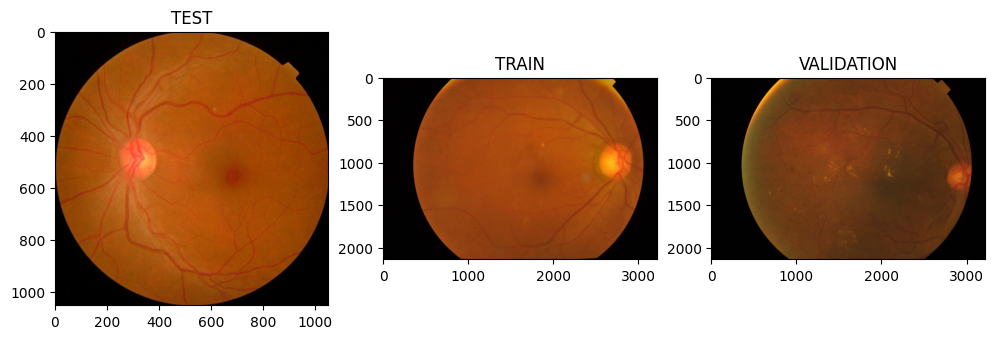

In [2]:
import matplotlib.pyplot as plt
import glob

# my_path = "drive/MyDrive/5980/"
my_path = "drive/MyDrive/"
test_image_path = "./" + my_path + "APTOS/test_images/test_images"
train_image_path = "./" + my_path + "APTOS/train_images/train_images"
val_image_path = "./" + my_path + "APTOS/val_images/val_images"

test_images = sorted(glob.glob(test_image_path + '/*.png'))
train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))

test_image = test_images[0]
train_image = train_images[0]
val_image = val_images[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(plt.imread(test_image), cmap='gray')
ax[0].set_title('TEST')

ax[1].imshow(plt.imread(train_image), cmap='gray')
ax[1].set_title('TRAIN')

ax[2].imshow(plt.imread(val_image), cmap='gray')
ax[2].set_title('VALIDATION')

plt.show()

In [3]:
import torch
import numpy as np

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Device: {device}")

2.5.1+cu121
Device: cuda


In [4]:
import os
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
from functools import lru_cache

class CustomDataset(Dataset):
    def __init__(self, image_dir, labels_csv, transform=None):
        self.image_dir = image_dir
        self.labels_df = pd.read_csv(labels_csv)
        self.transform = transform

        # Normalize IDs in the labels DataFrame
        self.labels_df['id_code'] = self.labels_df['id_code'].str.lower().str.strip()

    def __len__(self):
        return len(self.labels_df)

    @lru_cache(maxsize = 10_000)
    def __getitem__(self, idx):
        # Get image ID and label
        image_id = self.labels_df.iloc[idx]['id_code']
        label = self.labels_df.iloc[idx]['diagnosis']

        # Construct image path using os.path.join for platform-independent path handling
        image_path = os.path.join(self.image_dir, f"{image_id}.png")

        # Debug: Check the file path
        # print(f"Looking for: {image_path}")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"File not found: {image_path}")

        # Load the image
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label



Train Labels:
         id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0
Validation Labels:
         id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
Test Labels:
         id_code  diagnosis
0  e4dcca36ceb4          0
1  e4e343eaae2a          2
2  e4f12411fd85          4
3  e50b0174690d          0
4  e5197d77ec68          0


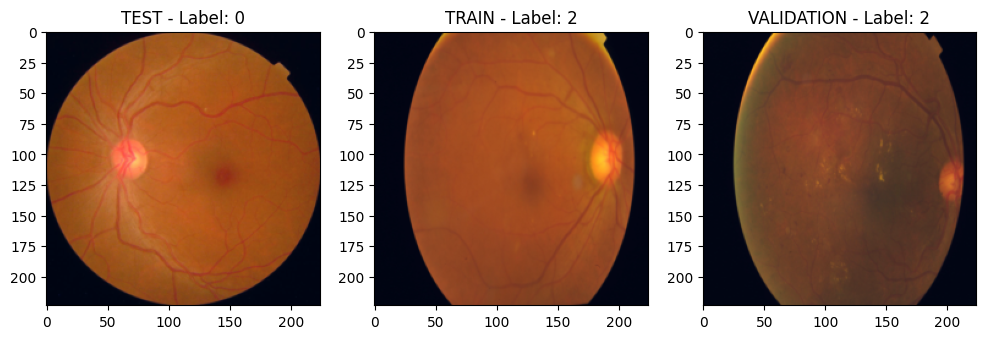

In [5]:
import pandas as pd
import glob
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os

test_image_path = "./" + my_path + "APTOS/test_images/test_images"
train_image_path = "./" + my_path + "APTOS/train_images/train_images"
val_image_path = "./" + my_path + "APTOS/val_images/val_images"

train_csv_path = "./" + my_path + "APTOS/train_1.csv"
val_csv_path = "./" + my_path + "APTOS/valid.csv"
test_csv_path = "./" + my_path + "APTOS/test.csv"

train_labels = pd.read_csv(train_csv_path)
val_labels = pd.read_csv(val_csv_path)
test_labels = pd.read_csv(test_csv_path)

train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))
test_images = sorted(glob.glob(test_image_path + '/*.png'))

# Verify CSV contents
print("Train Labels:\n", train_labels.head())
print("Validation Labels:\n", val_labels.head())
print("Test Labels:\n", test_labels.head())

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_and_transform(image_path, transform):
    image = Image.open(image_path)
    transformed_image = transform(image)
    transformed_image = transformed_image.permute(1, 2, 0).numpy()
    transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())
    return transformed_image

def get_label(image_path, labels_df):
    image_id = os.path.splitext(os.path.basename(image_path))[0].lower().strip()
    labels_df['id_code'] = labels_df['id_code'].str.lower().str.strip()
    if image_id in labels_df['id_code'].values:
        label = labels_df.loc[labels_df['id_code'] == image_id, 'diagnosis'].values[0]
        return label
    else:
        return "Label Not Found"

train_image_transformed = load_and_transform(train_images[0], transform)
val_image_transformed = load_and_transform(val_images[0], transform)
test_image_transformed = load_and_transform(test_images[0], transform)

train_label = get_label(train_images[0], train_labels)
val_label = get_label(val_images[0], val_labels)
test_label = get_label(test_images[0], test_labels)

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(test_image_transformed)
ax[0].set_title(f'TEST - Label: {test_label}')

ax[1].imshow(train_image_transformed)
ax[1].set_title(f'TRAIN - Label: {train_label}')

ax[2].imshow(val_image_transformed)
ax[2].set_title(f'VALIDATION - Label: {val_label}')

plt.show()


In [6]:
from torch.utils.data import DataLoader

from pathlib import Path

train_dataset = CustomDataset(
    image_dir="./" + my_path + "APTOS/train_images/train_images",
    labels_csv="./" + my_path + "APTOS/train_1.csv",
    transform=transform
)

val_dataset = CustomDataset(
    image_dir="./" + my_path + "APTOS/val_images/val_images",
    labels_csv="./" + my_path + "APTOS/valid.csv",
    transform=transform
)

test_dataset = CustomDataset(
    image_dir="./" + my_path + "APTOS/test_images/test_images",
    labels_csv="./" + my_path + "APTOS/test.csv",
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [7]:
# Manually check the first 5 images and their labels
for i in range(5):
    image, label = train_dataset[i]
    print(f"Image {i}: Label = {label}")
    print(f"Image Path: {train_dataset.image_dir}/{train_dataset.labels_df.iloc[i]['id_code']}.png")



Image 0: Label = 2
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1ae8c165fd53.png
Image 1: Label = 1
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1b329a127307.png
Image 2: Label = 4
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1b32e1d775ea.png
Image 3: Label = 0
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1b3647865779.png
Image 4: Label = 0
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1b398c0494d1.png


In [8]:
from tqdm.auto import tqdm


def verify_loader_size(dataloader, dataset):
    samples = 0
    for batch, labels in tqdm(dataloader):
        samples += len(batch)
    return samples == len(dataset)

# This will take awhile as the images are loaded into memory and cached for the first time.
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, val_dataset)
)


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
# Notice how much faster it is after caching!
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, val_dataset)
)

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [53]:
import torch
from torch import nn, optim
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from torchvision.models import densenet121, DenseNet121_Weights, densenet161, DenseNet161_Weights, densenet169, DenseNet169_Weights, densenet201, DenseNet201_Weights
import matplotlib.pyplot as plt

def initialize_model(num_classes, device):
    weights = EfficientNet_B7_Weights.DEFAULT
    model = efficientnet_b7(weights=weights)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model.to(device)

def initialize_model_densenet121(num_classes, device):
    weights = DenseNet121_Weights.DEFAULT
    model = densenet121(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

def initialize_model_densenet161(num_classes, device):
    weights = DenseNet161_Weights.DEFAULT
    model = densenet161(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

def initialize_model_densenet169(num_classes, device):
    weights = DenseNet169_Weights.DEFAULT
    model = densenet169(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

def initialize_model_densenet201(num_classes, device):
    weights = DenseNet201_Weights.DEFAULT
    model = densenet201(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

def test_model(model, test_loader):
    model.eval()
    true_labels = []
    predicted_probabilities = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = nn.Softmax(dim=1)(outputs)
            true_labels.extend(labels.cpu().numpy())
            predicted_probabilities.extend(probabilities.cpu().numpy())

    return np.array(true_labels), np.array(predicted_probabilities)

def plot_learning_curves(training_losses, validation_losses, model_name=''):
    # Plot epoch wise training and validation losses (both in the same plot)
    assert len(training_losses) == len(validation_losses)

    plt.figure(figsize=(10,6))
    plt.plot(training_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(validation_losses, label='Validation Loss', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(model_name + ' Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

def train_model(model, loss_module, optimizer, train_loader, valid_loader, device, path='efficientnetb7', epochs=20, model_name=''):
    training_losses = []
    validation_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{epochs}", leave=False, unit='batch')

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_module(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        training_losses.append(train_loss)

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_module(outputs, labels)
                running_loss += loss.item()

        valid_loss = running_loss / len(valid_loader)
        validation_losses.append(valid_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            torch.save({'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epoch': epoch + 1}, f"{path}_best.pth")
            print(f"Best model saved at epoch {epoch + 1}")

        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch + 1}, f"{path}_epoch_{epoch + 1}.pth")
    plot_learning_curves(training_losses, validation_losses, model_name)

    return training_losses, validation_losses


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 5

model = initialize_model(num_classes, device)

loss_module = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

model_densenet121 = initialize_model_densenet121(num_classes, device)
optimizer_densenet121 = optim.AdamW(model_densenet121.parameters(), lr=1e-4)

model_densenet161 = initialize_model_densenet161(num_classes, device)
optimizer_densenet161 = optim.AdamW(model_densenet161.parameters(), lr=1e-4)

model_densenet169 = initialize_model_densenet169(num_classes, device)
optimizer_densenet169 = optim.AdamW(model_densenet169.parameters(), lr=1e-4)

model_densenet201 = initialize_model_densenet201(num_classes, device)
optimizer_densenet201 = optim.AdamW(model_densenet201.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 154MB/s]
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 193MB/s] 
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 150MB/s]
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 165MB/s]


In [ ]:
try:
    train_losses, val_losses = train_model(
        model, loss_module, optimizer, train_loader, valid_loader,
         device=device, path="efficientnetb7", epochs=20, model_name='EfficientNet-B7'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.9406, Valid Loss: 0.9508
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.4977, Valid Loss: 0.7249
Best model saved at epoch 2


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

In [13]:
# Load the best model checkpoint
checkpoint = torch.load("efficientnetb7_epoch_8.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

true_labels, predicted_probabilities = test_model(model, test_loader)

def accuracy(true_labels, predicted_probabilities):
  predicted_labels = [elem.argmax() for elem in predicted_probabilities]
  correct = 0
  for i in range(len(true_labels)):
    if true_labels[i] == predicted_labels[i]:
      correct +=1
  return correct/len(true_labels)

print("Accuracy:", accuracy(true_labels, predicted_probabilities))


<ipython-input-13-b9bd1ff6d5b3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("efficientnetb7_epoch_19.pth", map_location=device)


Accuracy: 0.819672131147541


In [14]:
print(f"True Labels: {set(true_labels)}")
print(f"Predicted Probabilities: {predicted_probabilities[:10]}")  # Should contain values between 0 and 1


True Labels: {0, 1, 2, 3, 4}
Predicted Probabilities: [[9.99700189e-01 9.56936419e-05 5.88046260e-06 1.16429670e-04
  8.18306580e-05]
 [3.69706686e-06 9.41010803e-05 9.98999178e-01 3.94682487e-04
  5.08352590e-04]
 [1.39120641e-06 1.99316200e-05 4.53666398e-05 9.94477212e-01
  5.45613887e-03]
 [9.99650478e-01 9.34364289e-05 7.82412644e-06 1.33133188e-04
  1.15169496e-04]
 [9.98317361e-01 3.90282250e-04 5.19506066e-05 7.01400510e-04
  5.38936292e-04]
 [9.99704659e-01 8.02472787e-05 4.24876634e-06 1.13820650e-04
  9.70327601e-05]
 [7.32018725e-06 8.06816824e-05 3.47097665e-01 9.55773331e-03
  6.43256664e-01]
 [3.43728487e-07 8.85921690e-05 9.99721110e-01 3.37024612e-05
  1.56275986e-04]
 [4.94474898e-06 9.94546294e-01 5.27357170e-03 3.14268545e-05
  1.43826604e-04]
 [2.75275292e-04 8.31380635e-02 9.15889680e-01 2.10785132e-04
  4.86216799e-04]]


### ROC-AUC

In [39]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
def evaluate_roc_auc(true_labels, predicted_probabilities, model_name):
    # Binarize class labels
    true_labels_binarized = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure()

    # Set ROC curve colors
    colors = cycle(['lightsteelblue', 'cornflowerblue', 'royalblue', 'blue', 'darkblue'])

    # Plot ROC curve for each class
    for i, color in zip(range(5), colors):
        fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predicted_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Severity {i} ROC curve (area = {roc_auc[i]:0.2f})')

    # Plot micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_binarized.ravel(), predicted_probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"],
         linestyle=':', linewidth=2, color='salmon',
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')

    #Plot macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(5):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 5
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
         linestyle=':', linewidth=2, color='red',
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name + ' Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

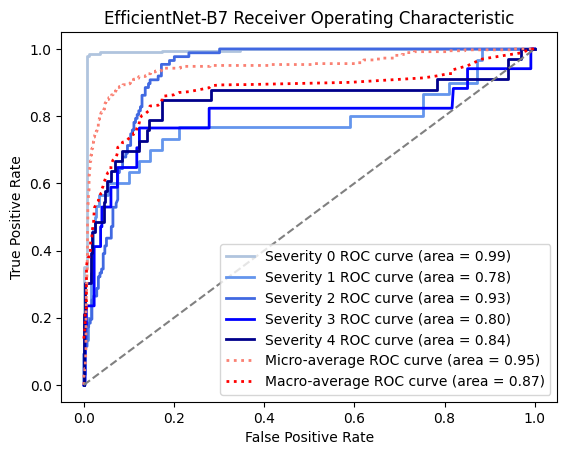

Severity 0 ROC-AUC: 0.99
Severity 1 ROC-AUC: 0.78
Severity 2 ROC-AUC: 0.93
Severity 3 ROC-AUC: 0.80
Severity 4 ROC-AUC: 0.84


In [40]:
roc_auc = evaluate_roc_auc(true_labels, predicted_probabilities, 'EfficientNet-B7')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc[cls]:.2f}")

### Confusion Matrix

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(true_labels, predicted_labels, model_name='', normalize=False):
    cm = confusion_matrix(true_labels, predicted_labels)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='viridis',
                xticklabels=range(5), yticklabels=range(5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name + ' Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.show()

    return cm

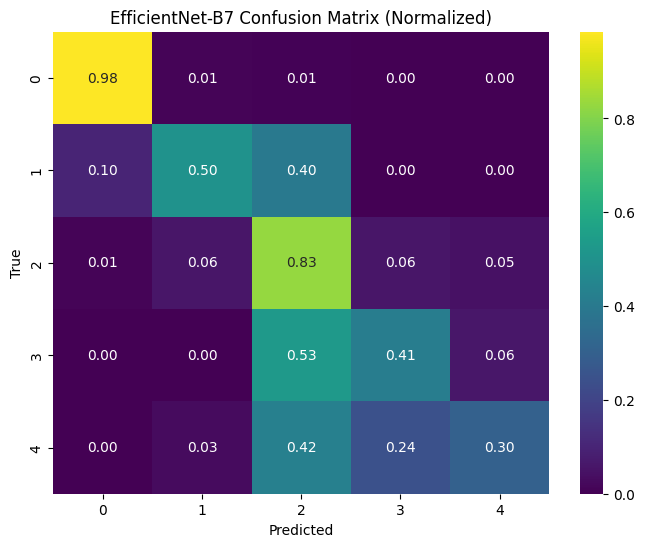

In [47]:
predicted_labels = np.argmax(predicted_probabilities, axis=1)
cm_normalized = plot_confusion_matrix(true_labels, predicted_labels, 'EfficientNet-B7', normalize=True)

### DenseNet

Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.7202, Valid Loss: 0.5214
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.3626, Valid Loss: 0.4652
Best model saved at epoch 2


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/20, Train Loss: 0.1804, Valid Loss: 0.5075


Training epoch 4/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4/20, Train Loss: 0.0927, Valid Loss: 0.6496


Training epoch 5/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5/20, Train Loss: 0.0729, Valid Loss: 0.6831


Training epoch 6/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6/20, Train Loss: 0.0635, Valid Loss: 0.5534


Training epoch 7/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 7/20, Train Loss: 0.0450, Valid Loss: 0.6016


Training epoch 8/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 8/20, Train Loss: 0.0368, Valid Loss: 0.6074


Training epoch 9/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 9/20, Train Loss: 0.0220, Valid Loss: 0.6573


Training epoch 10/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 10/20, Train Loss: 0.0197, Valid Loss: 0.6338


Training epoch 11/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 11/20, Train Loss: 0.0171, Valid Loss: 0.6680


Training epoch 12/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 12/20, Train Loss: 0.0184, Valid Loss: 0.5927


Training epoch 13/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 13/20, Train Loss: 0.0124, Valid Loss: 0.7352


Training epoch 14/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 14/20, Train Loss: 0.0081, Valid Loss: 0.7530


Training epoch 15/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 15/20, Train Loss: 0.0076, Valid Loss: 0.7509


Training epoch 16/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 16/20, Train Loss: 0.0091, Valid Loss: 0.7679


Training epoch 17/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 17/20, Train Loss: 0.0054, Valid Loss: 0.7791


Training epoch 18/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 18/20, Train Loss: 0.0041, Valid Loss: 0.7758


Training epoch 19/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 19/20, Train Loss: 0.0027, Valid Loss: 0.8036


Training epoch 20/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 20/20, Train Loss: 0.0019, Valid Loss: 0.7824


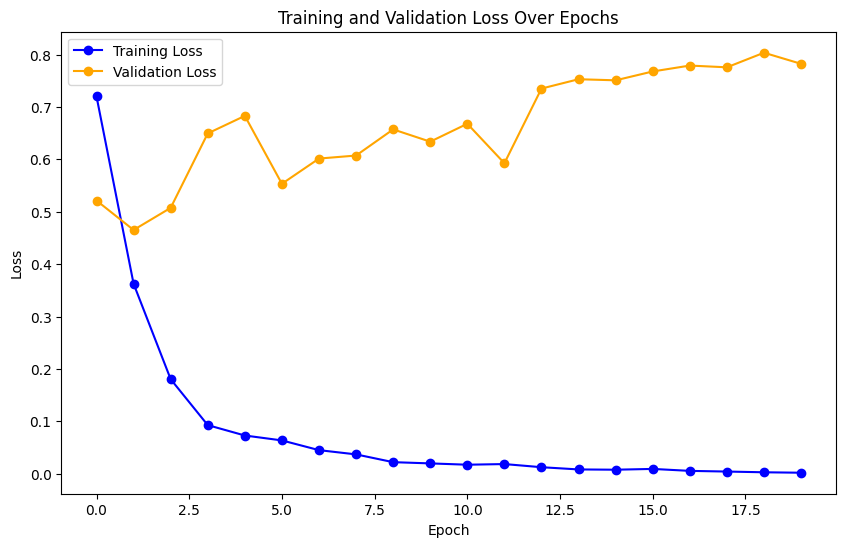

Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.6525, Valid Loss: 0.5358
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.3285, Valid Loss: 0.5041
Best model saved at epoch 2


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/20, Train Loss: 0.1512, Valid Loss: 0.5812


Training epoch 4/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4/20, Train Loss: 0.1127, Valid Loss: 0.7546


Training epoch 5/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5/20, Train Loss: 0.0740, Valid Loss: 0.6314


Training epoch 6/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6/20, Train Loss: 0.0556, Valid Loss: 0.6470


Training epoch 7/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 7/20, Train Loss: 0.0496, Valid Loss: 0.6309


Training epoch 8/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 8/20, Train Loss: 0.0371, Valid Loss: 0.5822


Training epoch 9/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 9/20, Train Loss: 0.0241, Valid Loss: 0.6458


Training epoch 10/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 10/20, Train Loss: 0.0198, Valid Loss: 0.5721


Training epoch 11/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 11/20, Train Loss: 0.0116, Valid Loss: 0.6599


Training epoch 12/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 12/20, Train Loss: 0.0081, Valid Loss: 0.6286


Training epoch 13/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 13/20, Train Loss: 0.0076, Valid Loss: 0.6448


Training epoch 14/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 14/20, Train Loss: 0.0054, Valid Loss: 0.6677


Training epoch 15/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 15/20, Train Loss: 0.0064, Valid Loss: 0.6641


Training epoch 16/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 16/20, Train Loss: 0.0053, Valid Loss: 0.7090


Training epoch 17/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 17/20, Train Loss: 0.0058, Valid Loss: 0.7157


Training epoch 18/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 18/20, Train Loss: 0.0028, Valid Loss: 0.7081


Training epoch 19/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 19/20, Train Loss: 0.0039, Valid Loss: 0.7392


Training epoch 20/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 20/20, Train Loss: 0.0020, Valid Loss: 0.6993


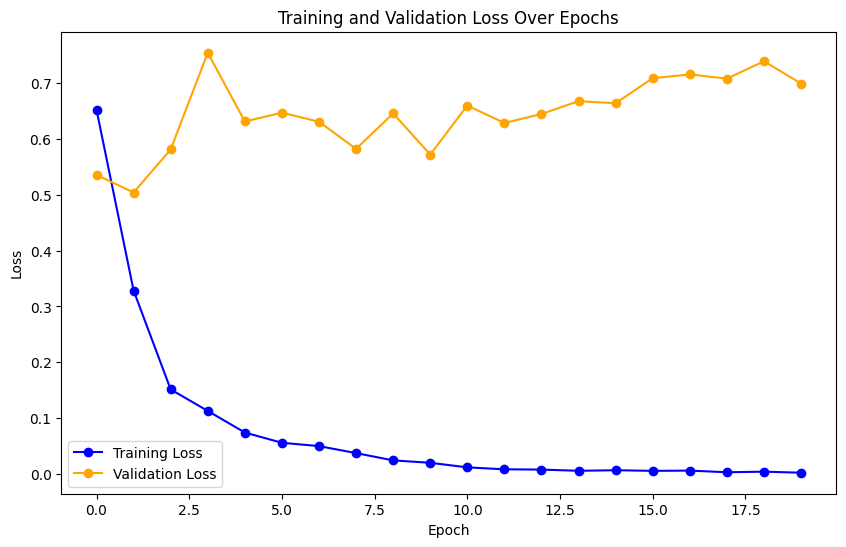

Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.6383, Valid Loss: 0.5161
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.3205, Valid Loss: 0.5078
Best model saved at epoch 2


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/20, Train Loss: 0.1492, Valid Loss: 0.5351


Training epoch 4/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4/20, Train Loss: 0.0882, Valid Loss: 0.6526


Training epoch 5/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5/20, Train Loss: 0.0680, Valid Loss: 0.6297


Training epoch 6/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6/20, Train Loss: 0.0434, Valid Loss: 0.6920


Training epoch 7/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 7/20, Train Loss: 0.0475, Valid Loss: 0.7045


Training epoch 8/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 8/20, Train Loss: 0.0377, Valid Loss: 0.6870


Training epoch 9/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 9/20, Train Loss: 0.0335, Valid Loss: 0.7540


Training epoch 10/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 10/20, Train Loss: 0.0553, Valid Loss: 0.7045


Training epoch 11/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 11/20, Train Loss: 0.0364, Valid Loss: 0.6956


Training epoch 12/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 12/20, Train Loss: 0.0248, Valid Loss: 0.6671


Training epoch 13/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 13/20, Train Loss: 0.0126, Valid Loss: 0.7151


Training epoch 14/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 14/20, Train Loss: 0.0093, Valid Loss: 0.7240


Training epoch 15/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 15/20, Train Loss: 0.0085, Valid Loss: 0.7303


Training epoch 16/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 16/20, Train Loss: 0.0045, Valid Loss: 0.7689


Training epoch 17/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 17/20, Train Loss: 0.0037, Valid Loss: 0.7577


Training epoch 18/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 18/20, Train Loss: 0.0021, Valid Loss: 0.7872


Training epoch 19/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 19/20, Train Loss: 0.0016, Valid Loss: 0.7881


Training epoch 20/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 20/20, Train Loss: 0.0015, Valid Loss: 0.7986


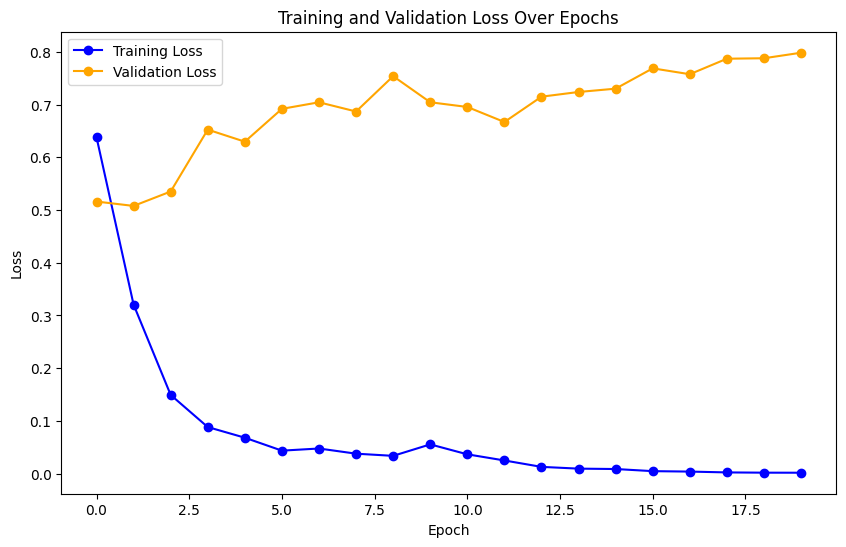

Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.6526, Valid Loss: 0.5017
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.3128, Valid Loss: 0.4640
Best model saved at epoch 2


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/20, Train Loss: 0.1332, Valid Loss: 0.5128


Training epoch 4/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4/20, Train Loss: 0.0888, Valid Loss: 0.6194


Training epoch 5/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5/20, Train Loss: 0.0671, Valid Loss: 0.6484


Training epoch 6/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6/20, Train Loss: 0.0625, Valid Loss: 0.7438


Training epoch 7/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 7/20, Train Loss: 0.0483, Valid Loss: 0.6243


Training epoch 8/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 8/20, Train Loss: 0.0347, Valid Loss: 0.7299


Training epoch 9/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 9/20, Train Loss: 0.0233, Valid Loss: 0.7522


Training epoch 10/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 10/20, Train Loss: 0.0125, Valid Loss: 0.7608


Training epoch 11/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 11/20, Train Loss: 0.0085, Valid Loss: 0.7742


Training epoch 12/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 12/20, Train Loss: 0.0076, Valid Loss: 0.7523


Training epoch 13/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 13/20, Train Loss: 0.0054, Valid Loss: 0.8175


Training epoch 14/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 14/20, Train Loss: 0.0068, Valid Loss: 0.7729


Training epoch 15/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 15/20, Train Loss: 0.0104, Valid Loss: 0.7671


Training epoch 16/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 16/20, Train Loss: 0.0035, Valid Loss: 0.7934


Training epoch 17/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 17/20, Train Loss: 0.0021, Valid Loss: 0.8048


Training epoch 18/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 18/20, Train Loss: 0.0018, Valid Loss: 0.8145


Training epoch 19/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 19/20, Train Loss: 0.0035, Valid Loss: 0.8253


Training epoch 20/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 20/20, Train Loss: 0.0058, Valid Loss: 0.8414


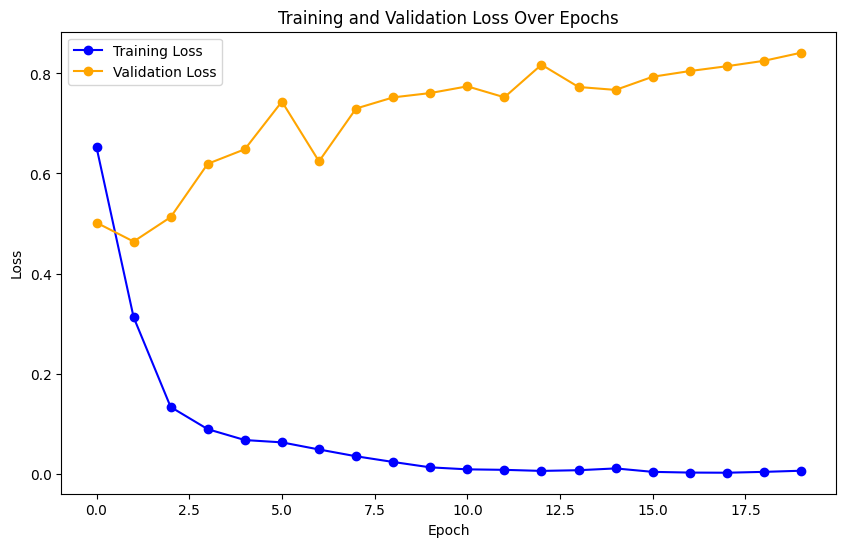

In [23]:
try:
    train_losses, val_losses = train_model(
        model_densenet121, loss_module, optimizer_densenet121, train_loader, valid_loader,
         device=device, path="densenet121", epochs=20, model_name='DenseNet-121'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

try:
    train_losses, val_losses = train_model(
        model_densenet161, loss_module, optimizer_densenet161, train_loader, valid_loader,
         device=device, path="densenet161", epochs=20, model_name='DenseNet-161'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

try:
    train_losses, val_losses = train_model(
        model_densenet169, loss_module, optimizer_densenet169, train_loader, valid_loader,
         device=device, path="densenet169", epochs=20, model_name='DenseNet-169'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

try:
    train_losses, val_losses = train_model(
        model_densenet201, loss_module, optimizer_densenet201, train_loader, valid_loader,
         device=device, path="densenet201", epochs=20, model_name='DenseNet-201'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

In [38]:
checkpoint_densenet121 = torch.load("densenet121_epoch_11.pth", map_location=device)
model_densenet121.load_state_dict(checkpoint_densenet121["model_state_dict"])

checkpoint_densenet161 = torch.load("densenet161_epoch_9.pth", map_location=device)
model_densenet161.load_state_dict(checkpoint_densenet161["model_state_dict"])

checkpoint_densenet169 = torch.load("densenet169_epoch_11.pth", map_location=device)
model_densenet169.load_state_dict(checkpoint_densenet169["model_state_dict"])

checkpoint_densenet201 = torch.load("densenet201_epoch_6.pth", map_location=device)
model_densenet201.load_state_dict(checkpoint_densenet201["model_state_dict"])

true_labels_densenet121, predicted_probabilities_densenet121 = test_model(model_densenet121, test_loader)
true_labels_densenet161, predicted_probabilities_densenet161 = test_model(model_densenet161, test_loader)
true_labels_densenet169, predicted_probabilities_densenet169 = test_model(model_densenet169, test_loader)
true_labels_densenet201, predicted_probabilities_densenet201 = test_model(model_densenet201, test_loader)

print(f"\nDenseNet-121 True Labels: {set(true_labels_densenet121)}")
print(f"DenseNet-161 True Labels: {set(true_labels_densenet161)}")
print(f"DenseNet-169 True Labels: {set(true_labels_densenet169)}")
print(f"DenseNet-201 True Labels: {set(true_labels_densenet201)}\n")

print(f"DenseNet-121 Predicted Probabilities: \n{predicted_probabilities_densenet121[:10]}\n")
print(f"DenseNet-161 Predicted Probabilities: \n{predicted_probabilities_densenet161[:10]}\n")
print(f"DenseNet-169 Predicted Probabilities: \n{predicted_probabilities_densenet169[:10]}\n")
print(f"DenseNet-201 Predicted Probabilities: \n{predicted_probabilities_densenet201[:10]}\n")


print("Accuracy DenseNet-121:", accuracy(true_labels_densenet121, predicted_probabilities_densenet121))
print("Accuracy DenseNet-161:", accuracy(true_labels_densenet161, predicted_probabilities_densenet161))
print("Accuracy DenseNet-169:", accuracy(true_labels_densenet169, predicted_probabilities_densenet169))
print("Accuracy DenseNet-201:", accuracy(true_labels_densenet201, predicted_probabilities_densenet201))


<ipython-input-38-0c93a3225cc6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_densenet121 = torch.load("densenet121_epoch_11.pth", map_location=device)
<ipytho


DenseNet-121 True Labels: {0, 1, 2, 3, 4}
DenseNet-161 True Labels: {0, 1, 2, 3, 4}
DenseNet-169 True Labels: {0, 1, 2, 3, 4}
DenseNet-201 True Labels: {0, 1, 2, 3, 4}

DenseNet-121 Predicted Probabilities: 
[[9.9814177e-01 6.9510052e-04 4.0755473e-04 1.5222152e-04 6.0344546e-04]
 [5.0224273e-05 5.6764821e-04 9.9922061e-01 3.2907868e-05 1.2860283e-04]
 [4.3553275e-05 2.7885739e-05 6.4175561e-06 9.7263992e-01 2.7282121e-02]
 [9.8766553e-01 1.0143836e-02 6.9948897e-04 4.6592765e-04 1.0251831e-03]
 [9.9204707e-01 5.5476185e-04 2.8219393e-03 6.2674424e-04 3.9494904e-03]
 [9.9797970e-01 7.7010994e-04 2.8796750e-04 2.7214651e-04 6.9000904e-04]
 [1.2133908e-04 8.0314589e-05 7.4685299e-01 3.1469346e-03 2.4979842e-01]
 [3.5399087e-03 4.7797868e-01 2.4129288e-01 6.4318045e-04 2.7654529e-01]
 [2.7210839e-05 9.9982256e-01 1.2328252e-04 1.7181941e-06 2.5341988e-05]
 [6.5202423e-04 3.3960296e-04 9.9877089e-01 1.4356508e-04 9.3912480e-05]]

DenseNet-161 Predicted Probabilities: 
[[9.9750155e-01 9.13

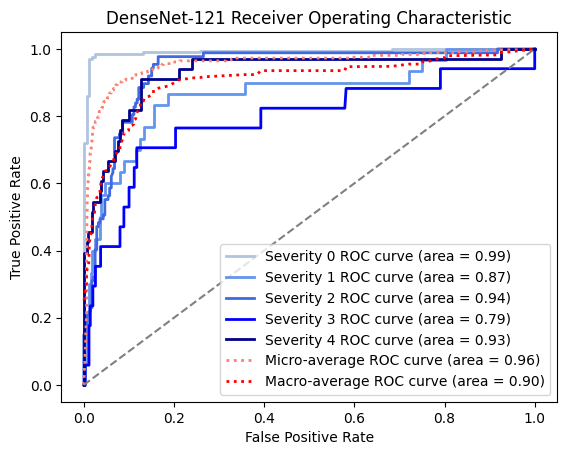

Severity 0 ROC-AUC: 0.99
Severity 1 ROC-AUC: 0.87
Severity 2 ROC-AUC: 0.94
Severity 3 ROC-AUC: 0.79
Severity 4 ROC-AUC: 0.93


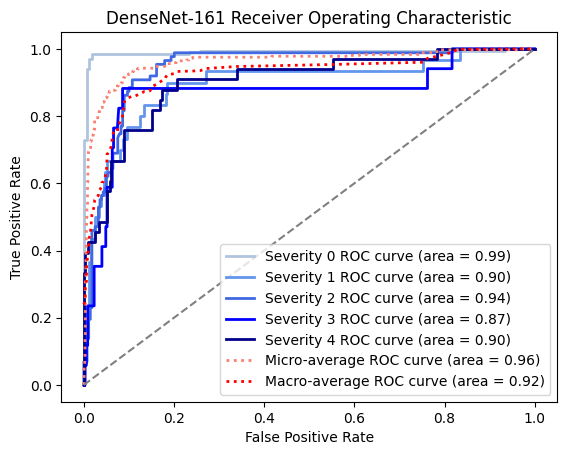

Severity 0 ROC-AUC: 0.99
Severity 1 ROC-AUC: 0.90
Severity 2 ROC-AUC: 0.94
Severity 3 ROC-AUC: 0.87
Severity 4 ROC-AUC: 0.90


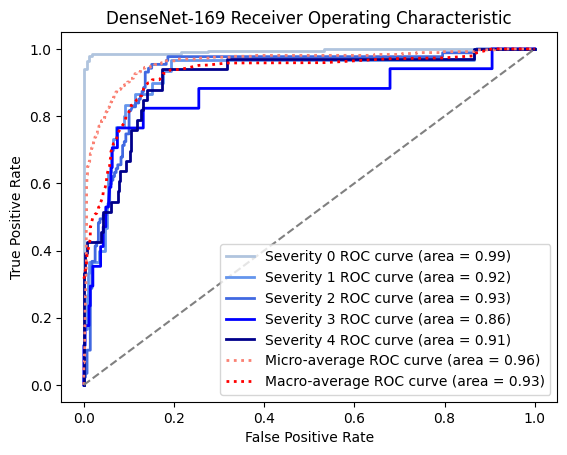

Severity 0 ROC-AUC: 0.99
Severity 1 ROC-AUC: 0.92
Severity 2 ROC-AUC: 0.93
Severity 3 ROC-AUC: 0.86
Severity 4 ROC-AUC: 0.91


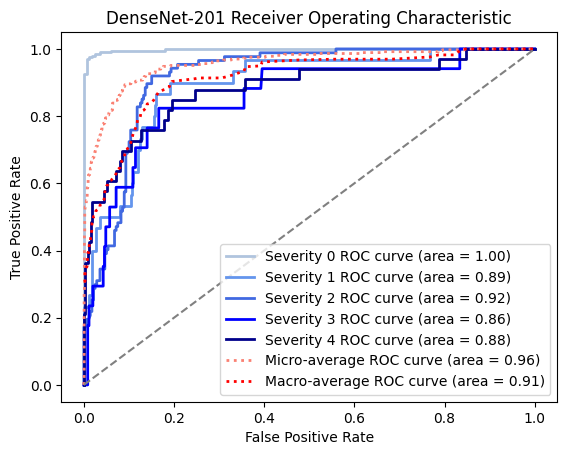

Severity 0 ROC-AUC: 1.00
Severity 1 ROC-AUC: 0.89
Severity 2 ROC-AUC: 0.92
Severity 3 ROC-AUC: 0.86
Severity 4 ROC-AUC: 0.88


In [41]:
roc_auc_densenet121 = evaluate_roc_auc(true_labels_densenet121, predicted_probabilities_densenet121, 'DenseNet-121')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc_densenet121[cls]:.2f}")

roc_auc_densenet161 = evaluate_roc_auc(true_labels_densenet161, predicted_probabilities_densenet161, 'DenseNet-161')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc_densenet161[cls]:.2f}")

roc_auc_densenet169 = evaluate_roc_auc(true_labels_densenet169, predicted_probabilities_densenet169, 'DenseNet-169')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc_densenet169[cls]:.2f}")

roc_auc_densenet201 = evaluate_roc_auc(true_labels_densenet201, predicted_probabilities_densenet201, 'DenseNet-201')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc_densenet201[cls]:.2f}")


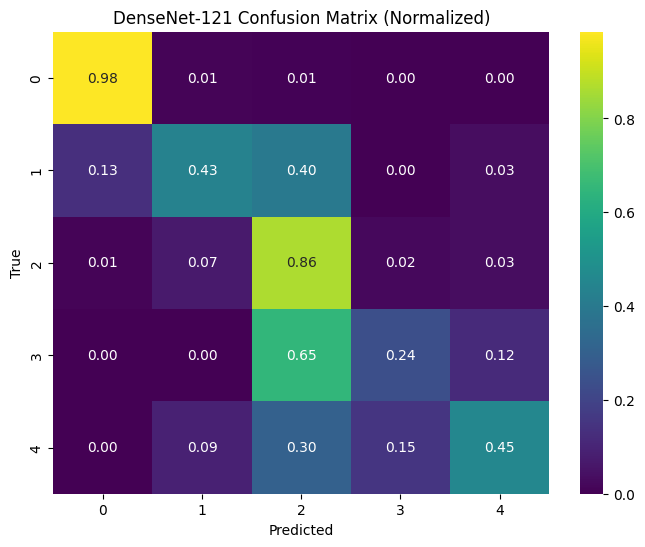

DenseNet-121 Confusion Matrix:
 [[0.98492462 0.01005025 0.00502513 0.         0.        ]
 [0.13333333 0.43333333 0.4        0.         0.03333333]
 [0.01149425 0.06896552 0.86206897 0.02298851 0.03448276]
 [0.         0.         0.64705882 0.23529412 0.11764706]
 [0.         0.09090909 0.3030303  0.15151515 0.45454545]]


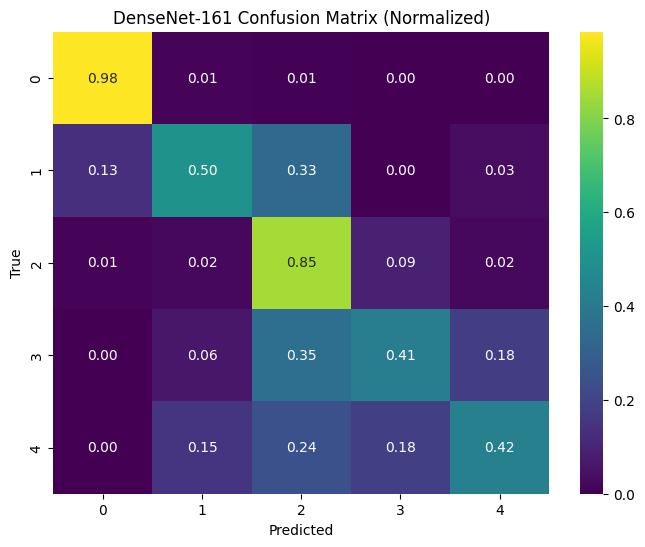

DenseNet-161 Confusion Matrix:
 [[0.98492462 0.01005025 0.00502513 0.         0.        ]
 [0.13333333 0.5        0.33333333 0.         0.03333333]
 [0.01149425 0.02298851 0.85057471 0.09195402 0.02298851]
 [0.         0.05882353 0.35294118 0.41176471 0.17647059]
 [0.         0.15151515 0.24242424 0.18181818 0.42424242]]


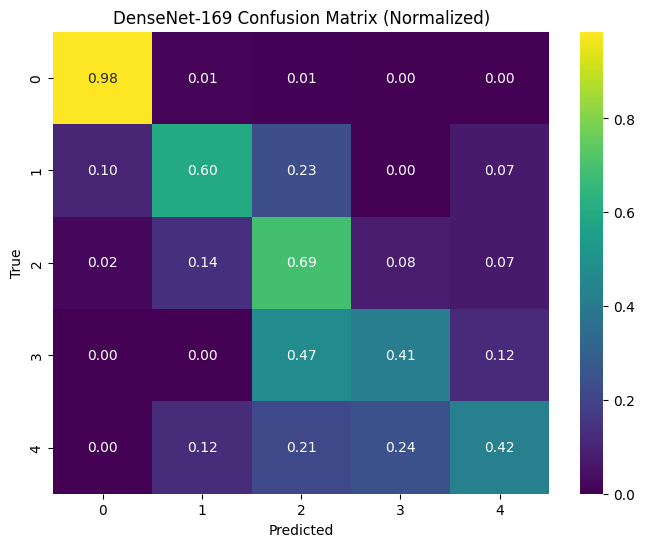

DenseNet-169 Confusion Matrix:
 [[0.98492462 0.01005025 0.00502513 0.         0.        ]
 [0.1        0.6        0.23333333 0.         0.06666667]
 [0.02298851 0.13793103 0.68965517 0.08045977 0.06896552]
 [0.         0.         0.47058824 0.41176471 0.11764706]
 [0.         0.12121212 0.21212121 0.24242424 0.42424242]]


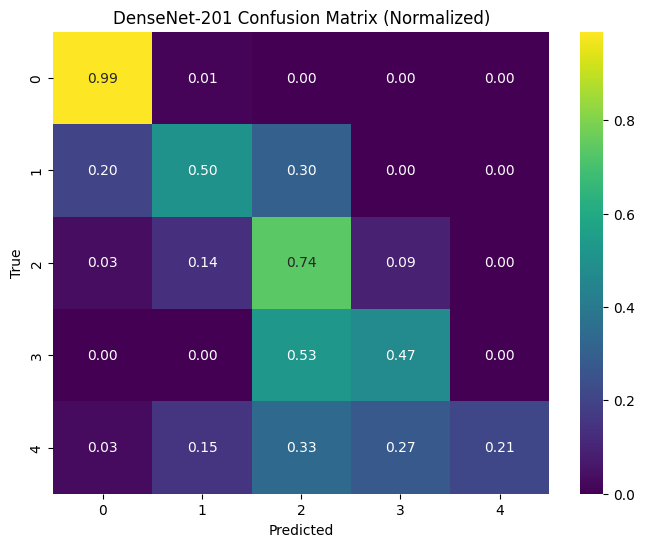

DenseNet-201 Confusion Matrix:
 [[0.98994975 0.01005025 0.         0.         0.        ]
 [0.2        0.5        0.3        0.         0.        ]
 [0.03448276 0.13793103 0.73563218 0.09195402 0.        ]
 [0.         0.         0.52941176 0.47058824 0.        ]
 [0.03030303 0.15151515 0.33333333 0.27272727 0.21212121]]


In [51]:
predicted_labels_densenet121 = np.argmax(predicted_probabilities_densenet121, axis=1)
cm_densenet121 = plot_confusion_matrix(true_labels_densenet121, predicted_labels_densenet121, 'DenseNet-121', normalize=True)
print(f'DenseNet-121 Confusion Matrix:\n {cm_densenet121}')

predicted_labels_densenet161 = np.argmax(predicted_probabilities_densenet161, axis=1)
cm_densenet161 = plot_confusion_matrix(true_labels_densenet161, predicted_labels_densenet161, 'DenseNet-161', normalize=True)
print(f'DenseNet-161 Confusion Matrix:\n {cm_densenet161}')

predicted_labels_densenet169 = np.argmax(predicted_probabilities_densenet169, axis=1)
cm_densenet169 = plot_confusion_matrix(true_labels_densenet169, predicted_labels_densenet169, 'DenseNet-169', normalize=True)
print(f'DenseNet-169 Confusion Matrix:\n {cm_densenet169}')

predicted_labels_densenet201 = np.argmax(predicted_probabilities_densenet201, axis=1)
cm_densenet201 = plot_confusion_matrix(true_labels_densenet201, predicted_labels_densenet201, 'DenseNet-201', normalize=True)
print(f'DenseNet-201 Confusion Matrix:\n {cm_densenet201}')